### CSC 5601: Term Project - Isolation Forest (Anomaly Detection) - Sumedha Sanjeev

In [1]:
import pandas as pd
import numpy as np
import sklearn.ensemble as skl_e
from isolation_forest import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns

#### Data Loading & Preprocessing

In [2]:
creditcard = pd.read_csv('data/creditcard.csv')
creditcard.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
creditcard.isnull().sum().sum()

0

In [4]:
creditcard['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

As seen by the counts above, data is severely imbalanced.

Let's take a look at a plot of two features (V1 vs. Amount) and see where the frauds lie:

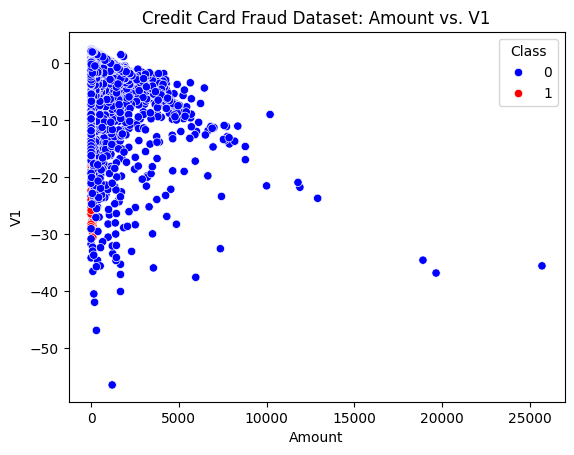

In [6]:
# plotting anomalies over 'Amount' and 'V1'
sns.scatterplot(data=creditcard, x='Amount', y='V1', hue='Class', palette={0: "blue", 1: "red"})
plt.title("Credit Card Fraud Dataset: Amount vs. V1")
plt.show()

In [7]:
proportion_outliers = 492 / (492+284315)
proportion_outliers

0.001727485630620034

In [8]:
X = creditcard.drop(columns=['Class','Time']).to_numpy()
y = creditcard['Class']
X.shape

(284807, 29)

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Anomaly Detection with Isolation Forest

- The following sections are based on the **assumption** that **anomaly/outlier = fraud**


**Class**:
- 0: Represents normal transactions.
- 1: Represents fraudulent/anomalous transactions (ground truth)


**Anomaly**:
- 0: Predicted as normal by the Isolation Forest
- 1: Predicted as fraudulent/anomalous by the Isolation Forest

##### Anomaly Detection using implemented `isolation_forest.IsolationForest`

In [10]:
# stratify data based on the labels
stratify_labels = y
num_trees = 100  # number of isolation trees
sub_sampling_size = 512
max_features = 10  # limit number of features for splitting

In [11]:
isolation_forest = IsolationForest(
    t=num_trees, 
    sub_sampling_size=sub_sampling_size,
    max_features=max_features,
    stratify=y
)

In [12]:
isolation_forest.fit(X_scaled)

In [13]:
# calculating anomaly scores
creditcard['anomaly_score'] = [isolation_forest.anomaly_score(x) for x in X_scaled]

In [14]:
# get the distribution of the anomaly scores
min_score = min(creditcard['anomaly_score'])
max_score = max(creditcard['anomaly_score'])
mean_score = creditcard['anomaly_score'].mean()
median_score = creditcard['anomaly_score'].median()
print("Anomaly score minumum: ", min_score)
print("Anomaly score maximum: ", max_score)
print("Mean Anomaly score minumum: ", mean_score)
print("Median Anomaly score minumum: ", median_score)

Anomaly score minumum:  0.2939417256928773
Anomaly score maximum:  0.8605548543785436
Mean Anomaly score minumum:  0.30597928061922036
Median Anomaly score minumum:  0.2939417256928773


In [15]:
# threshold for binary labels
threshold = 0.5 * (min_score + mean_score)  # halfway between min and mean
print(threshold)

# map anomaly predictions - 1 for anomaly, 0 for normal
creditcard['anomaly'] = creditcard['anomaly_score'].apply(lambda score: 1 if score < threshold else 0)

result = creditcard.groupby(['Class', 'anomaly']).size()
print(result)

0.29996050315604883
Class  anomaly
0      0           70804
       1          213511
1      0             455
       1              37
dtype: int64


In [16]:
if_tn = creditcard[['Class', 'anomaly']].value_counts().loc[(0, 0)]
if_fp = creditcard[['Class', 'anomaly']].value_counts().loc[(0, 1)]
if_fn = creditcard[['Class', 'anomaly']].value_counts().loc[(1, 0)]
if_tp = creditcard[['Class', 'anomaly']].value_counts().loc[(1, 1)]

| Class	| Anomaly | Count | Meaning |
| -- | -- | -- | -- |
| 0 | 0 | 67274 | True normal transactions, predicted as normal (True Negatives). |
| 0 | 1 | 217041 | True normal transactions, predicted as anomalies (False Positives). |
| 1 | 0 | 459 | True anomalies (fraud), predicted as normal (False Negatives). |
| 1 | 1 | 33 | True anomalies (fraud), predicted as anomalies (True Positives) |

##### Anomaly Detection using `sklearn.ensemble.IsolationForest`

In [17]:
iso_forest = skl_e.IsolationForest(contamination='auto', random_state=42)
creditcard['skl_anomaly_score'] = iso_forest.fit_predict(X_scaled)

# map anomaly predictions - 1 for anomaly, 0 for normal
creditcard['skl_anomaly'] = creditcard['skl_anomaly_score'].map({1: 0, -1: 1})  

# eval anomalies
print(creditcard[['Class', 'skl_anomaly']].value_counts())

Class  skl_anomaly
0      0              274629
       1                9686
1      1                 402
       0                  90
Name: count, dtype: int64


In [18]:
skl_tn = creditcard[['Class', 'skl_anomaly']].value_counts().loc[(0, 0)]
skl_fp = creditcard[['Class', 'skl_anomaly']].value_counts().loc[(0, 1)]
skl_fn = creditcard[['Class', 'skl_anomaly']].value_counts().loc[(1, 0)]
skl_tp = creditcard[['Class', 'skl_anomaly']].value_counts().loc[(1, 1)]

| Class	| Anomaly | Count | Meaning |
| -- | -- | -- | -- |
| 0 | 0 | 274629 | True normal transactions, predicted as normal (True Negatives). |
| 0 | 1 | 9686 | True normal transactions, predicted as anomalies (False Positives). |
| 1 | 1 | 402 | True anomalies (fraud), predicted as normal (False Negatives). |
| 1 | 0 | 90 | True anomalies (fraud), predicted as anomalies (True Positives) |

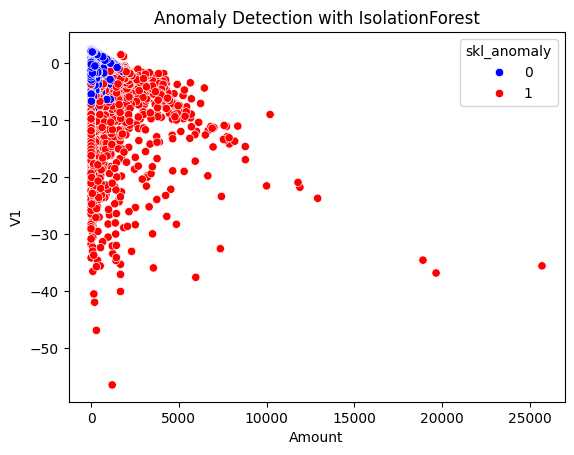

In [19]:
# plotting anomalies over 'Amount' and 'V1'
sns.scatterplot(data=creditcard, x='Amount', y='V1', hue='skl_anomaly', palette={0: "blue", 1: "red"})
plt.title("Anomaly Detection with IsolationForest")
plt.show()

#### Evaluation

**Evaluating the implemented Isolation Forest:**

Accuracy:

In [20]:
if_accuracy = (if_tn + if_tp) / (if_tp + if_fp + if_fn + if_tn)
if_accuracy

0.24873335276169475

Precision (Positive Predictive Value):

In [21]:
if_precision = if_tp / (if_tp + if_fp)
if_precision

0.00017326315395133646

Recall (Sensitivity/True Positive Rate):

In [22]:
if_recall = if_tp / (if_tp + if_fn)
if_recall

0.07520325203252033

F1 Score:

In [23]:
if_f1 = 2 * ((if_precision * if_recall)/(if_precision + if_recall))
if_f1

0.0003457297701364231

AUC-PR (better for imbalanced datasets):

In [24]:
precision, recall, thresholds = precision_recall_curve(creditcard['Class'], creditcard['anomaly'])
auc_pr = average_precision_score(creditcard['Class'], creditcard['anomaly'])
print(f"AUC-PR: {auc_pr:.4f}")

AUC-PR: 0.0016


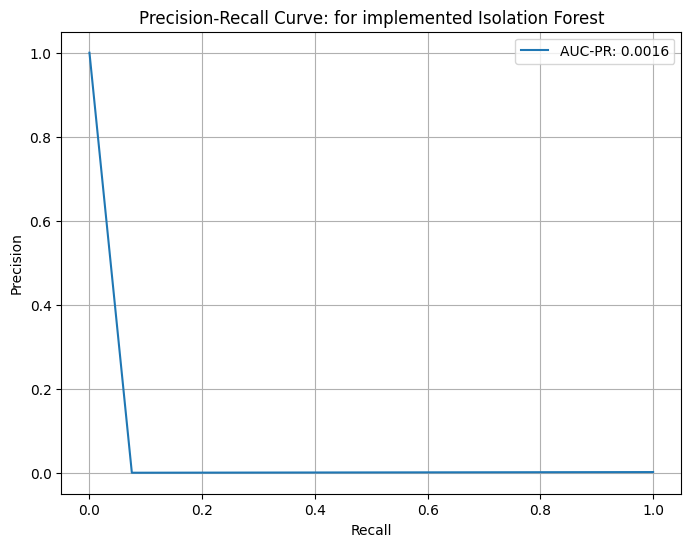

In [25]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AUC-PR: {auc_pr:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve: for implemented Isolation Forest')
plt.legend()
plt.grid()
plt.show()

**Evaluating `sklearn.ensemble.IsolationForest`**


Accuracy:

In [26]:
skl_accuracy = (skl_tn + skl_tp) / (skl_tp + skl_fp + skl_fn + skl_tn)
skl_accuracy

0.9656750009655661

Precision (Positive Predictive Value):

In [27]:
skl_precision = skl_tp / (skl_tp + skl_fp)
skl_precision

0.039849325931800156

Recall (Sensitivity/True Positive Rate):

In [28]:
skl_recall = skl_tp / (skl_tp + skl_fn)
skl_recall

0.8170731707317073

F1 Score:

In [29]:
skl_f1 = 2 * ((skl_precision * skl_recall)/(skl_precision + skl_recall))
skl_f1

0.07599243856332703

AUC-PR (better for imbalanced datasets):

In [30]:
precision, recall, thresholds = precision_recall_curve(creditcard['Class'], creditcard['skl_anomaly'])
auc_pr = average_precision_score(creditcard['Class'], creditcard['skl_anomaly'])
print(f"AUC-PR: {auc_pr:.4f}")

AUC-PR: 0.0329


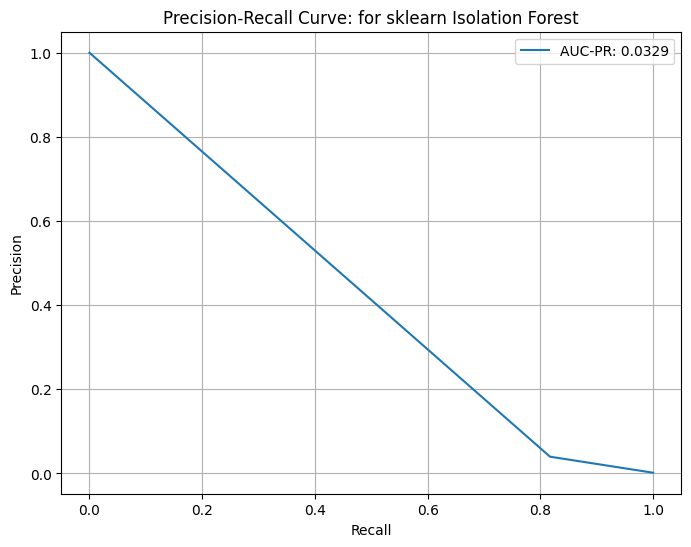

In [31]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AUC-PR: {auc_pr:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve: for sklearn Isolation Forest')
plt.legend()
plt.grid()
plt.show()